In [147]:
# general
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter

import pickle


import collections
from pandas import DataFrame
from scipy.cluster.hierarchy import linkage, dendrogram







# spark
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SQLContext, Row
# sk learn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt 




# similarity
from sklearn.metrics import jaccard_similarity_score

In [2]:
# personality scores
#data1 = pd.read_excel('data/pers_scores_1098.xlsx')
# articles by some traveler
#data2 = pd.read_excel('data/articles_159.xlsx')
# traveler profile
data3 = pd.read_excel('data/users_full_7034.xlsx')
# traveler and reviews
data4 = pd.read_excel('data/reviews_32618_for_1098_users_with_location.xlsx')

In [3]:
null_age = data3.ageRange.isnull()
null_gender = data3.gender.isnull()
null_style = data3.travelStyle.isnull()

In [4]:
filtered_data3 = data3[data3.totalPoints > 1000][~null_age][~null_gender][~null_style]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [5]:
filtered_data3 = filtered_data3[['username', 'ageRange', 'gender', 'travelStyle']]
filtered_data3.head()

,username,ageRange,gender,travelStyle
1,0BKI0,25-34,female,"Foodie, Nature Lover, Urban Explorer"
7,14beacon,35-49,male,"Foodie, Trendsetter, Like a Local, Luxury Trav..."
12,1975mark,25-34,male,"Foodie, Beach Goer, Thrifty Traveller, Nightli..."
15,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
17,1Angie,18-24,female,"Beach Goer, Vegetarian, Urban Explorer"


In [6]:
filtered_data4 = data4[['id', 'username', 'type', 'title', 'text', 'rating', 'taObjectCity']]
filtered_data4;


In [7]:
attraction_only = filtered_data4.type == 'Attractions'
filtered_data4 = filtered_data4[attraction_only]

In [8]:
filtered_data4.head()

,id,username,type,title,text,rating,taObjectCity
2,3,007solotraveler,Attractions,Brilliant - Well worth a visit(s),Great Museum - abslutely worth making the time...,5,Stockholm
87,88,124_10,Attractions,Had everything,Noting to dislike about this village. It has e...,5,Corsham
95,96,12ReasonsWhy,Attractions,"Definite must do, wonderful experience!",We were lucky enough to be the only two people...,5,Takayama
102,103,14beacon,Attractions,Better than expected,"Went with my wife, parents, two kids (7) & (12...",5,Charleston
103,104,14beacon,Attractions,Solid Park - Good Bang for the Buck,My family and I just came back from spending a...,4,Farmingdale


In [9]:
data3_merge_4 = pd.merge(filtered_data4, filtered_data3, on=['username'])
data3_merge_4.head()

,id,username,type,title,text,rating,taObjectCity,ageRange,gender,travelStyle
0,103,14beacon,Attractions,Better than expected,"Went with my wife, parents, two kids (7) & (12...",5,Charleston,35-49,male,"Foodie, Trendsetter, Like a Local, Luxury Trav..."
1,104,14beacon,Attractions,Solid Park - Good Bang for the Buck,My family and I just came back from spending a...,4,Farmingdale,35-49,male,"Foodie, Trendsetter, Like a Local, Luxury Trav..."
2,362,19Cam,Attractions,See it before its gone,The box is only a temporary exhibit while cons...,4,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
3,363,19Cam,Attractions,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
4,378,19Cam,Attractions,Fantastic,"After reading all the hype about this show, I ...",5,London,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."


In [10]:
span_mask1 = (data3_merge_4.username == 'AnaS1')
span_mask2 = (data3_merge_4.username == 'DaniLK')
span_mask3 = (data3_merge_4.username == 'Aprile_24')
non_city_mask = (data3_merge_4.taObjectCity == 'California')

In [11]:
data3_merge_4 = data3_merge_4[~span_mask1][~span_mask2][~span_mask3][~non_city_mask]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [12]:
# cities with more than 4 reviews
popular_city = []
for item, value in Counter(data3_merge_4.taObjectCity).items():
    if value > 7:
        popular_city.append(item)
print(len(popular_city))

56


In [13]:
final_df = data3_merge_4[data3_merge_4.taObjectCity.isin(popular_city)]
final_df.head()

,id,username,type,title,text,rating,taObjectCity,ageRange,gender,travelStyle
2,362,19Cam,Attractions,See it before its gone,The box is only a temporary exhibit while cons...,4,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
3,363,19Cam,Attractions,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,Berlin,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
4,378,19Cam,Attractions,Fantastic,"After reading all the hype about this show, I ...",5,London,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
5,414,19Cam,Attractions,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,Kuala Lumpur,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
18,778,1oldseagull,Attractions,THIS SHOULD BE A FIRST STOP,"First thing, this visiter center was not easy ...",5,Chattanooga,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."


In [14]:
final_df.shape

(963, 10)

# NMF model


In [24]:
X = np.array([[1, 1, 3], [2, 1, 4], [3, 1.2, 5], [4, 1, 3], [5, 0.8, 4], [6, 1, 5]])


In [25]:
X_df = pd.DataFrame(data = X)
#  columns=['user','city','rating']
X_df

,0,1,2
0,1.0,1.0,3.0
1,2.0,1.0,4.0
2,3.0,1.2,5.0
3,4.0,1.0,3.0
4,5.0,0.8,4.0
5,6.0,1.0,5.0


In [32]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [33]:
H

array([[2.21803764, 0.37620259, 1.71324087],
       [1.452353  , 1.21912311, 4.46312145]])

In [34]:
W

array([[0.        , 0.68300273],
       [0.42469943, 0.73000053],
       [0.83390742, 0.79482885],
       [1.79214877, 0.00507249],
       [2.23458995, 0.03315586],
       [2.64379794, 0.09798417]])

In [42]:
W[5].dot(H.T[2])

4.966777925454759

# ALS model
## create spark dataframe

In [78]:
# Build our Spark Session and Context

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc
sqlContext = SQLContext(sc)

In [79]:
temp_rdd = final_df[['username', 'taObjectCity', 'rating']]


In [80]:
user_dict_df = pd.DataFrame(temp_rdd.username.unique(), columns = ['username'])
city_dict_df = pd.DataFrame(temp_rdd.taObjectCity.unique(), columns = ['taObjectCity'])

In [81]:
user_dict_df.head()

,username
0,19Cam
1,1oldseagull
2,2093
3,23stationroad
4,29grapes


In [82]:
user_temp = user_dict_df.reset_index()
city_temp = city_dict_df.reset_index()

In [83]:
user_df = user_temp.rename(columns = {'index':'user_id'})
city_df = city_temp.rename(columns = {'index':'city_id'})


In [84]:
user_df.shape

(208, 2)

In [85]:
city_df.shape

(56, 2)

In [86]:
208*56

11648

In [87]:
# dictionary contains unique value for each user
#temp1_df = pd.merge(left, right, on='username')


In [88]:
user_df.head(10)

,user_id,username
0,0,19Cam
1,1,1oldseagull
2,2,2093
3,3,23stationroad
4,4,29grapes
5,5,2toots
6,6,422
7,7,4bigdogsCalgary
8,8,6079max
9,9,678855


In [89]:
city_df.head()

,city_id,taObjectCity
0,0,Berlin
1,1,London
2,2,Kuala Lumpur
3,3,Chattanooga
4,4,St. Petersburg


In [90]:
left = temp_rdd
right1 = user_df
right2 = city_df


up_temp_df = pd.merge(left, right1, on = 'username')
result_df = pd.merge(up_temp_df, right2, on = 'taObjectCity')

In [91]:
result_df.head(10)

,username,taObjectCity,rating,user_id,city_id
0,19Cam,Berlin,4,0,0
1,19Cam,Berlin,3,0,0
2,6079max,Berlin,5,8,0
3,6079max,Berlin,5,8,0
4,Bumbi17,Berlin,4,94,0
5,Bumbi17,Berlin,3,94,0
6,Bumbi17,Berlin,3,94,0
7,Bumbi17,Berlin,5,94,0
8,CJIMI,Berlin,5,99,0
9,CJIMI,Berlin,5,99,0


In [92]:

agg_dict = {'rating':'median'}
util_matrix = result_df.groupby(['user_id', 'city_id']).agg(agg_dict).reset_index()

In [93]:
util_matrix.head()

,user_id,city_id,rating
0,0,0,3.5
1,0,1,5.0
2,0,2,4.0
3,1,3,5.0
4,1,4,5.0


In [94]:
util_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 3 columns):
user_id    449 non-null int64
city_id    449 non-null int64
rating     449 non-null float64
dtypes: float64(1), int64(2)
memory usage: 10.6 KB


In [95]:
util_matrix.shape

(449, 3)

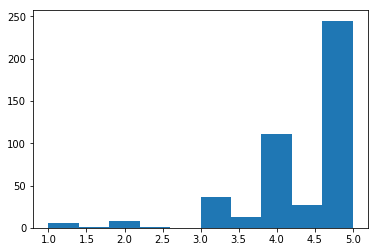

In [29]:
plt.hist(util_matrix.rating);

In [30]:
#util_matrix.shape

In [96]:
    schema = StructType( [
    StructField('user', IntegerType(), True),
    StructField('city', IntegerType(), True),
    StructField('rating', FloatType(), True)]
)

In [97]:
# creating spark dataframe
#spark_df = sqlContext.createDataFrame(final_rdd, schema)

spark_df = sqlContext.createDataFrame(util_matrix, schema)


In [98]:
#train, test = spark_df.randomSplit([0.85, 0.15], seed=427471138)

In [99]:
test.show()

+----+----+------+
|user|city|rating|
+----+----+------+
|   1|   4|   5.0|
|   1|   5|   5.0|
|   2|   6|   4.0|
|   7|  16|   4.0|
|   7|  17|   5.0|
|   9|  21|   4.5|
|  13|   2|   3.5|
|  20|   8|   3.5|
|  20|   9|   5.0|
|  20|  38|   5.0|
|  27|  15|   4.0|
|  27|  17|   5.0|
|  30|  20|   5.0|
|  31|  15|   5.0|
|  33|  36|   5.0|
|  39|  37|   5.0|
|  41|  39|   5.0|
|  43|  19|   4.5|
|  47|  11|   5.0|
|  49|  26|   5.0|
+----+----+------+
only showing top 20 rows



In [100]:
als_model = ALS(userCol='user',
                itemCol='city',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=15
               )

In [125]:
als_recommender = als_model.fit(spark_df)
als_recommender

ALS_432998ec9ba5195653d6

In [126]:
predictions = als_recommender.transform(test)


In [127]:
user_factor_df = als_recommender.userFactors.toPandas()

In [128]:
user_factor_df.tail(10)

,id,features
198,109,"[0.21960453689098358, 0.38068944215774536, 0.5..."
199,119,"[0.3474847376346588, 0.44106218218803406, 0.73..."
200,129,"[0.3856968283653259, 0.8335927724838257, 0.715..."
201,139,"[0.301262229681015, 0.510736882686615, 0.53730..."
202,149,"[0.048186108469963074, 0.10428865253925323, 0...."
203,159,"[0.353498250246048, 0.7316778302192688, 0.7627..."
204,169,"[0.3692573010921478, 0.7333199977874756, 0.760..."
205,179,"[0.06925108283758163, 0.5910173654556274, 1.22..."
206,189,"[0.0, 0.0, 0.0, 1.3584983348846436, 0.0, 0.0, ..."
207,199,"[0.14801350235939026, 0.8483789563179016, 1.06..."


In [129]:
item_factor_df = als_recommender.itemFactors.toPandas()

In [148]:
user_df = pd.read_pickle('src/user_factor_df.pkl')

In [149]:
item_df = pd.read_pickle('src/item_factor_df.pkl')

In [150]:
user_df.head()

,id,features
0,0,"[0.052830565720796585, 0.5680032968521118, 0.0..."
1,10,"[0.08755596727132797, 0.5332696437835693, 0.05..."
2,20,"[0.20748959481716156, 0.3947450518608093, 0.0,..."
3,30,"[0.15829311311244965, 0.29818713665008545, 0.1..."
4,40,"[0.2609822452068329, 0.2876499593257904, 0.030..."


In [145]:
user_df.features[10]

'[0.01533648744225502, 0.27583181858062744, 0.6643658876419067, 0.19901108741760254, 0.5352938771247864, 0.11077322065830231, 0.5207207202911377, 0.08845271915197372, 0.10690970718860626, 0.061266012489795685, 0.25728487968444824, 0.23047767579555511, 0.8079668879508972, 0.2950819134712219, 0.39722147583961487]'

In [153]:
np.dot(user_df.features[120], item_df.features[50])

2.83641854466153

In [137]:
df_predictions.fillna(0,inplace=True)
df_predictions.head()

,user,city,rating,prediction
0,49,26,5.0,4.536008
1,135,26,5.0,5.835579
2,164,27,5.0,0.000000
3,108,12,5.0,4.103354
4,200,22,5.0,3.933136


In [156]:
df_predictions[(df_predictions.user == 200) & (df_predictions.city == 16)].shape[0] == 0

True

In [154]:
(df_predictions[(df_predictions.user == 200) & (df_predictions.city == 16)].prediction) == []

Series([], Name: prediction, dtype: bool)

In [125]:
predictions[(predictions.user == '200')].show()

+----+----+------+----------+
|user|city|rating|prediction|
+----+----+------+----------+
| 200|  22|   5.0|  3.933136|
+----+----+------+----------+



In [42]:
#pred = predictions[(predictions.user == '200') & (predictions.city == '22')].select("prediction").collect()


In [118]:
foo = predictions.prediction

In [121]:
foo.prediction.

NameError: name 'isNull' is not defined

In [ ]:
predictions.show(20)

In [102]:
pred = predictions[(predictions.user == '100') & (predictions.city == '13')].select("prediction").collect()

In [123]:
pred[0][0]

AttributeError: 'list' object has no attribute 'show'

In [111]:
type(pred[0][0])

float

In [110]:
(pred[0][0]) == float(nan)

NameError: name 'nan' is not defined

In [112]:
pred[0][0] == 0

False

In [44]:
from sklearn.metrics import mean_squared_error
df_pred = predictions.toPandas()
pred = df_pred.prediction

actual = df_pred.rating
mse = mean_squared_error(actual, pred.fillna(pred.median()))
print("ALS model''s MSE: ", np.sqrt(mse))

ALS model''s MSE:  1.1025872


In [45]:
#df_pred.head()

# Hybrid model
## user-only matrix

In [34]:
feature_temp = final_df[['username', 'ageRange', 'gender', 'travelStyle']]
feature_temp.head(20)

,username,ageRange,gender,travelStyle
2,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
3,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
4,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
5,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
18,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
25,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
26,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
32,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
33,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
40,2093,35-49,female,"Like a Local, History Buff, Urban Explorer"


In [35]:
feature_temp = feature_temp.drop_duplicates()

In [36]:
feature_temp.head()

,username,ageRange,gender,travelStyle
2,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu..."
18,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler..."
40,2093,35-49,female,"Like a Local, History Buff, Urban Explorer"
83,23stationroad,50-64,female,"Foodie, Like a Local, Thrifty Traveller"
88,29grapes,65+,male,"Foodie, 60+ Traveler, Like a Local, Nature Lov..."


In [37]:
style_lst = [item.split(', ') for item in feature_temp.travelStyle]
style_serie = pd.Series(style_lst)


In [38]:
feature_temp['new_travel'] = style_serie.values

In [39]:
#feature_temp.append(pd.Series(style_lst), columns= 'travel_style')

In [40]:
# for item in style_lst:
#     print(item)

In [41]:
feature_temp.head()

,username,ageRange,gender,travelStyle,new_travel
2,19Cam,25-34,male,"Vegetarian, Urban Explorer, Art and Architectu...","[Vegetarian, Urban Explorer, Art and Architect..."
18,1oldseagull,65+,male,"Foodie, Beach Goer, History Buff, 60+ Traveler...","[Foodie, Beach Goer, History Buff, 60+ Travele..."
40,2093,35-49,female,"Like a Local, History Buff, Urban Explorer","[Like a Local, History Buff, Urban Explorer]"
83,23stationroad,50-64,female,"Foodie, Like a Local, Thrifty Traveller","[Foodie, Like a Local, Thrifty Traveller]"
88,29grapes,65+,male,"Foodie, 60+ Traveler, Like a Local, Nature Lov...","[Foodie, 60+ Traveler, Like a Local, Nature Lo..."


In [42]:
style_matrix = feature_temp['new_travel'].apply(pd.Series) # 19 styles
style_df = pd.get_dummies(style_matrix.apply(pd.Series).stack()).sum(level=0).rename(columns = lambda x : x)

In [43]:
right = style_df

In [44]:
right.head()

,60+ Traveler,Art and Architecture Lover,Backpacker,Beach Goer,Eco-tourist,Family Hoilday Maker,Foodie,History Buff,Like a Local,Luxury Traveller,Nature Lover,Nightlife Seeker,Peace and Quiet Seeker,Shopping Fanatic,Thrifty Traveller,Thrill Seeker,Trendsetter,Urban Explorer,Vegetarian
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
18,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
40,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
83,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
88,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,1,0


In [45]:
feature_temp = pd.get_dummies(feature_temp, columns = ['ageRange', 'gender'])

In [46]:
feature_temp.head()

,username,travelStyle,new_travel,ageRange_25-34,ageRange_35-49,ageRange_50-64,ageRange_65+,gender_female,gender_male
2,19Cam,"Vegetarian, Urban Explorer, Art and Architectu...","[Vegetarian, Urban Explorer, Art and Architect...",1,0,0,0,0,1
18,1oldseagull,"Foodie, Beach Goer, History Buff, 60+ Traveler...","[Foodie, Beach Goer, History Buff, 60+ Travele...",0,0,0,1,0,1
40,2093,"Like a Local, History Buff, Urban Explorer","[Like a Local, History Buff, Urban Explorer]",0,1,0,0,1,0
83,23stationroad,"Foodie, Like a Local, Thrifty Traveller","[Foodie, Like a Local, Thrifty Traveller]",0,0,1,0,1,0
88,29grapes,"Foodie, 60+ Traveler, Like a Local, Nature Lov...","[Foodie, 60+ Traveler, Like a Local, Nature Lo...",0,0,0,1,0,1


In [47]:
left = feature_temp

In [48]:
feature_temp = left.join(right)

In [49]:
feature_final = feature_temp.drop(['travelStyle', 'new_travel', 'gender_male','60+ Traveler', 'username'], axis =1)

In [50]:
feature_final.reset_index(drop=True, inplace=True)

In [51]:
feature_final.head()

,ageRange_25-34,ageRange_35-49,ageRange_50-64,ageRange_65+,gender_female,Art and Architecture Lover,Backpacker,Beach Goer,Eco-tourist,Family Hoilday Maker,...,Luxury Traveller,Nature Lover,Nightlife Seeker,Peace and Quiet Seeker,Shopping Fanatic,Thrifty Traveller,Thrill Seeker,Trendsetter,Urban Explorer,Vegetarian
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0


In [52]:
invert_feature = feature_final.T

In [53]:
invert_feature.shape

(23, 208)

In [58]:
invert_feature[50] #male, ageRange_35-49, Art and Architecture Lover, 
# Thrifty Traveller, Luxury Traveller, Family Hoilday Maker,
# Like a Local *4

ageRange_25-34                0
ageRange_35-49                1
ageRange_50-64                0
ageRange_65+                  0
gender_female                 0
Art and Architecture Lover    1
Backpacker                    0
Beach Goer                    0
Eco-tourist                   0
Family Hoilday Maker          1
Foodie                        1
History Buff                  0
Like a Local                  1
Luxury Traveller              1
Nature Lover                  0
Nightlife Seeker              0
Peace and Quiet Seeker        0
Shopping Fanatic              0
Thrifty Traveller             1
Thrill Seeker                 0
Trendsetter                   0
Urban Explorer                0
Vegetarian                    0
Name: 50, dtype: uint8

In [73]:
invert_feature[30] #female, ageRange_50-64 
#Beach Goer, History Buff, Nature Lover,Vegetarian *3

ageRange_25-34                0
ageRange_35-49                0
ageRange_50-64                1
ageRange_65+                  0
gender_female                 1
Art and Architecture Lover    0
Backpacker                    0
Beach Goer                    1
Eco-tourist                   0
Family Hoilday Maker          0
Foodie                        1
History Buff                  1
Like a Local                  0
Luxury Traveller              0
Nature Lover                  1
Nightlife Seeker              0
Peace and Quiet Seeker        0
Shopping Fanatic              0
Thrifty Traveller             0
Thrill Seeker                 0
Trendsetter                   0
Urban Explorer                0
Vegetarian                    1
Name: 30, dtype: uint8

In [139]:
invert_feature[163] # female, ageRange_50-64, Luxury Traveller, Shopping Fanatic, Urban Explorer *2
invert_feature[183] # ageRange_25-34, female, Beach Goer, Nightlife Seeker, Urban Explorer *1
invert_feature[151] # male, ageRange_50-64,Family Hoilday Maker, History Buff, Thrifty Traveller *5
invert_feature[41] # male, ageRange_35-49 ,Like a Local, Thrill Seeker, Nightlife Seeker *6
invert_feature[12] # female, ageRange_25-34 , Luxury Traveller, Peace and Quiet Seeker, Shopping Fanatic,Trendsetter 
#Urban Explorer 
invert_feature[62] 

ageRange_25-34                0
ageRange_35-49                1
ageRange_50-64                0
ageRange_65+                  0
gender_female                 0
Art and Architecture Lover    0
Backpacker                    0
Beach Goer                    0
Eco-tourist                   0
Family Hoilday Maker          0
Foodie                        1
History Buff                  0
Like a Local                  1
Luxury Traveller              0
Nature Lover                  0
Nightlife Seeker              0
Peace and Quiet Seeker        0
Shopping Fanatic              0
Thrifty Traveller             0
Thrill Seeker                 0
Trendsetter                   0
Urban Explorer                1
Vegetarian                    0
Name: 62, dtype: uint8

In [ ]:
invert_feature[183]

In [134]:
jaccard_similarity_score(invert_feature[12], invert_feature[41])

0.5217391304347826

In [1]:
jaccard_similarity_score(invert_feature[151], invert_feature[41])

NameError: name 'jaccard_similarity_score' is not defined

In [100]:
jaccard_similarity_score(invert_feature[163], invert_feature[183])

0.6956521739130435

In [ ]:
jaccard_similarity_score(invert_feature[50], invert_feature[1])

In [94]:
jaccard_similarity_score(invert_feature[50], invert_feature[1])

0.6086956521739131

In [ ]:
jaccard_similarity_score(invert_feature[50], invert_feature[1])

In [67]:
#final_rdd.groupby(['city_id', 'user_id'])
final_rdd.head()

NameError: name 'final_rdd' is not defined

In [ ]:
# df = final_rdd.copy()
# final_rdd.groupby(['city_id', 'user_id']).rating_float.mean()

In [ ]:
def get_rating(df,uid,cid):
    try:
        return df[(df.user_id == uid) & (df.city_id == cid)].rating_float.values[0]
    except:
        return None

In [ ]:
x = get_rating(util_matrix,0,34)
print(x)

In [ ]:
abc = util_matrix[util_matrix.city_id == 5]
abc

In [ ]:
for i in abc.user_id.values:
    print (i)
    

In [168]:
def jaccard_sim_score(udi, cid, user_matrix, util_matrix):
    ''' 
    takes in user(index) and item
    returns jaccard similarity score
    '''
    overall_rating = 0
    overall_sim = 0
    final_score = 0
    
    filtered_user = util_matrix[util_matrix.city_id == cid]
    #print(filtered_user)
    for user in filtered_user.user_id.values: 
        sim_score = jaccard_similarity_score(invert_feature[udi], invert_feature[user])
        rating = filtered_user[(filtered_user.user_id == user)].rating.values[0]
        overall_rating += sim_score * rating
        overall_sim +=sim_score

    if overall_sim != 0:
        final_score = overall_rating / overall_sim
    else:
        final_score = 3
        
    return final_score

In [96]:
user_i = 18
item = 20 
user_matrix = invert_feature
utility_matrix = util_matrix
jaccard_sim_score(user_i, item, invert_feature, util_matrix)

4.0276497695852544

In [1]:
test_list = [16, 31, 2, 57, 21, 53, 50]

In [100]:

# # overall score


# for i in test_list:
#     user_i = 200
#     city = i
#     user_matrix = invert_feature
#     utility_matrix = util_matrix

#     als_score = predictions[(predictions.user == str(user_i)) & (predictions.city == str(city))] \
#                 .select("prediction").collect()[0][0]
#     jacc_sim_score = jaccard_sim_score(user_i, item, invert_feature, util_matrix)

#     final_score = 0.5 * jacc_sim_score + 0.5 * als_score
#     final_score

IndexError: list index out of range

In [8]:

# overall score

final_score_lst = []
for i in test_list:
    user_i = 200
    city = i
    print(city)
    user_matrix = invert_feature
    utility_matrix = util_matrix

    als_score = df_predictions[(df_predictions.user == user_i) & (df_predictions.city == city)] \
                .prediction
    #print(als_score)
    jacc_sim_score = jaccard_sim_score(user_i, city, invert_feature, util_matrix)
    #print(jacc_sim_score)
    if als_score.shape[0] == 0:
        final_score = jacc_sim_score
    else:
        final_score = 0.5 * jacc_sim_score + 0.5 * als_score
    
    final_pair = (city, final_score)
    final_score_lst.append(final_pair)
    
final_score_lst

16


NameError: name 'invert_feature' is not defined

In [13]:
test_rates = [(4.735294117647059, 55), (4.757575757575757, 28), (4.0, 34), (4.244897959183673, 41), (4.641414141414142, 49), (4.732394366197184, 5)]

In [16]:
test_rates

[(4.735294117647059, 55),
 (4.757575757575757, 28),
 (4.0, 34),
 (4.244897959183673, 41),
 (4.641414141414142, 49),
 (4.732394366197184, 5)]

In [19]:
for x, y in test_rates:
    #print(sorted(test_rates))

SyntaxError: unexpected EOF while parsing (<ipython-input-19-0b543cddf5a9>, line 2)

In [21]:
top = sorted(test_rates, reverse = True)[:3]

In [22]:
for x,y in top:
    print(y)

28
55
5


In [ ]:
#df_grouped.describe().T

In [ ]:
#df_combined = pd.DataFrame(data = df_grouped.rating_float, index = df_grouped.user_id, columns = df_grouped.city_id )

In [ ]:
#df_combined.head()

In [ ]:
df_combined = df_combined.groupby(['user_id']).sum()

In [ ]:
df_combined.index[1]